Begun 2/1/25

Doing all the chi2 tests on all 264 maps after changing w2 to w2w4 everywhere. Using cuts identified in data_quality_larger_set_w2w4_20250201.ipynb.

Results are in angle_calc_1738357443

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import pandas as pd
import nawrapper as nw
import yaml
import time
import healpy as hp
from scipy import optimize as op
import os
from scipy.stats.distributions import chi2
from itertools import combinations

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1738357443/angle_calc_1738357443_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

264
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut'])


In [4]:
# Implementing automatic data cuts
cut_flags = np.zeros(n_maps)
ivar_sums = np.zeros(n_maps)
all_errbars = np.zeros(n_maps)
residual_sums = np.zeros(n_maps)
angles_rad = np.zeros(n_maps)
errbars_rad = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    all_errbars[i] = spectra_dict[maps[i]]['meas_errbar']
    ivar_sums[i] = spectra_dict[maps[i]]['ivar_sum']
    residual_sums[i] = spectra_dict[maps[i]]['residual_sum']
    angles_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_angle'])
    errbars_rad[i] = np.deg2rad(spectra_dict[maps[i]]['meas_errbar'])

# Extracting map info and results into separate arrays for ease of access
# Not using numpy arrays at first to more easily put strings and arrays in the list
map_arrays = []
map_timestamps = []
estimators = []
covariances = []
all_e2xe2 = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    estimators.append(spectra_dict[maps[i]]['estimator'])
    covariances.append(spectra_dict[maps[i]]['covariance'])
    all_e2xe2.append(spectra_dict[maps[i]]['E2xE2'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
estimators = np.array(estimators)
covariances = np.array(covariances)
all_e2xe2 = np.array(all_e2xe2)

# Doing cuts
ivar_cutoff = 2.5
residual_cutoff = 1900
    
print("Total number of maps: ", n_maps)
# Identifying maps that weren't cut by the galaxy mask
cut_good = np.where(cut_flags != 1)[0]
print("Maps passing galaxy mask cut: ", len(cut_good))
# Using the super small errorbars to identify the failed fits - there were none in this run
errbar_good = np.where(all_errbars>0.1)[0]
print("Maps passing bad fit cut: ", len(errbar_good))
# Using residual cutoff of 2000 - cuts come from analysis in data_quality_larger_set_corrected_mode_count_20241212.ipynb
residual_good = np.where(residual_sums<residual_cutoff)[0]
print("Maps passing residual cut: ", len(residual_good))
# Using ivar cutoff of 4.0
ivar_good = np.where(ivar_sums>ivar_cutoff)[0]
print("Maps passing ivar cut: ", len(ivar_good))
# Taking the intersection of these four sets to get those maps that pass all cuts
set_pass_all_cuts = np.intersect1d(np.intersect1d(np.intersect1d(cut_good,errbar_good),residual_good),ivar_good)
print("Maps passing all four cuts: ", len(set_pass_all_cuts))
print(set_pass_all_cuts)

Total number of maps:  264
Maps passing galaxy mask cut:  249
Maps passing bad fit cut:  246
Maps passing residual cut:  202
Maps passing ivar cut:  189
Maps passing all four cuts:  173
[  0   1   2   6   7   8  13  19  20  21  22  23  24  25  26  27  28  29
  30  37  38  39  46  47  48  49  51  56  57  58  59  60  61  62  63  64
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99 100 102 104
 105 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130 131 132
 134 135 136 137 140 141 142 143 144 145 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 163 173 174 175 176 177 178 179 180 181 182 183
 185 186 187 188 189 190 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 208 210 211 212 213 217 218 219 221 222 224 225 227 228 231 232
 233 243 244 245 247 250 251 255 258 259 263]


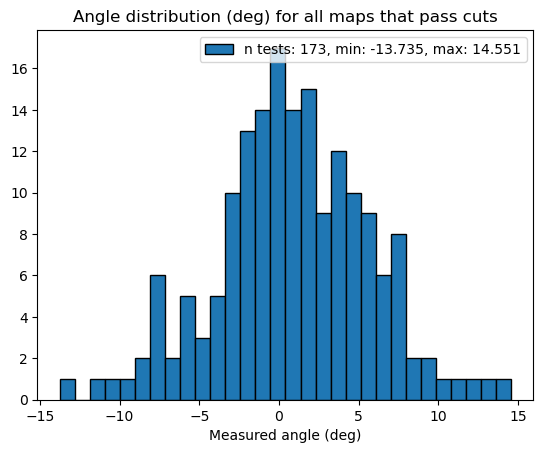

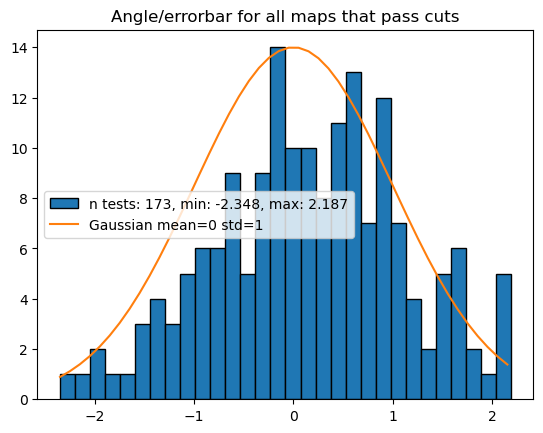

In [29]:
angles_deg = np.rad2deg(angles_rad)
errbars_deg = np.rad2deg(errbars_rad)
plt.hist(angles_deg[set_pass_all_cuts],bins=30, edgecolor='black',
        label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle distribution (deg) for all maps that pass cuts")
plt.xlabel("Measured angle (deg)")
plt.legend()
plt.show()
plt.close()

# The ratio angle/errbar should be normally distributed with std=1
n, bins, _ = plt.hist(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts],bins=30, edgecolor='black',
                     label=f'n tests: {len(set_pass_all_cuts)}, min: {np.min(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}, max: {np.max(angles_deg[set_pass_all_cuts]/errbars_deg[set_pass_all_cuts]):.3f}')
plt.title("Angle/errorbar for all maps that pass cuts")
x = np.arange(np.min(bins),np.max(bins),0.1)
#print(bins)
# assuming mean of zero and std=1
plt.plot(x, np.max(n)*np.exp(-x**2/2),label='Gaussian mean=0 std=1')
plt.legend()
plt.show()
plt.close()

In [6]:
# Checking chi2 for the model fit of estimator-theory for all maps passing cuts 
chi2_good_maps = []
pte_good_maps = []
all_theory_covs = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
ell = spectra_dict[maps[0]]['ell']
bin_size = 200
nu_b = (2*ell+1)*bin_size

for idx in set_pass_all_cuts:
    #null = 1.0*estimators[idx] - all_e2xe2[idx]*np.sin(2*angles_rad[idx])
    null = 1.0*estimators[idx] - test_CAMB_EE*np.sin(2*angles_rad[idx])
    theory_cov = 2*test_CAMB_EE**2 * ((np.sin(2*angles_rad[idx])**2/nu_b)+2*np.cos(2*angles_rad[idx])**2*errbars_rad[idx]**2)
    sum_cov = covariances[idx] + theory_cov
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)
    all_theory_covs.append(theory_cov)
chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)
all_theory_covs = np.array(all_theory_covs)

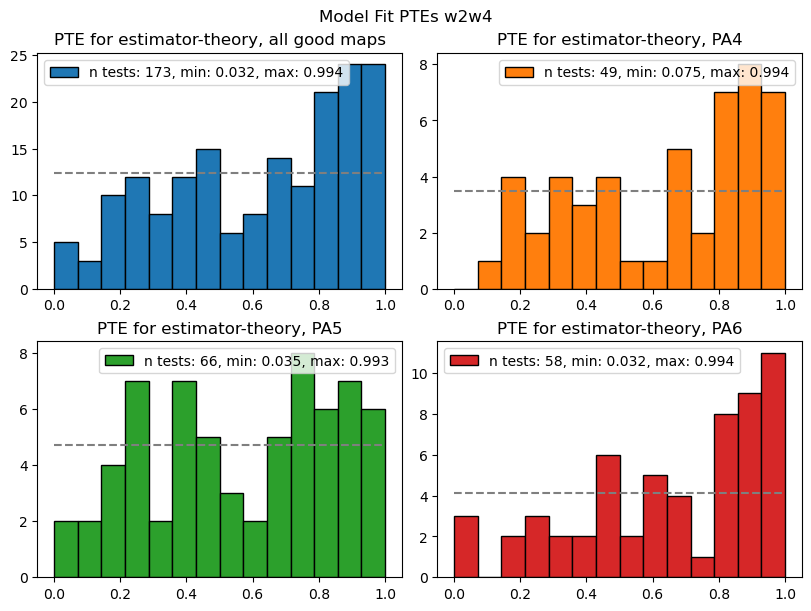

In [32]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Model Fit PTEs w2w4")
# All maps
axs[0,0].hist(pte_good_maps,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps)}, min: {np.min(pte_good_maps):.3f}, max: {np.max(pte_good_maps):.3f}')
axs[0,0].hlines(len(pte_good_maps)/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for estimator-theory, all good maps")
axs[0,0].legend()
# pa4
idx_pa4 = np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]
axs[0,1].hist(pte_good_maps[idx_pa4], bins=nbins,range=(0.0,1.0), color='tab:orange', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa4])}, min: {np.min(pte_good_maps[idx_pa4]):.3f}, max: {np.max(pte_good_maps[idx_pa4]):.3f}')
axs[0,1].hlines(len(pte_good_maps[idx_pa4])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for estimator-theory, PA4")
axs[0,1].legend()
# pa5
idx_pa5 = np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]
axs[1,0].hist(pte_good_maps[idx_pa5], bins=nbins,range=(0.0,1.0), color='tab:green', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa5])}, min: {np.min(pte_good_maps[idx_pa5]):.3f}, max: {np.max(pte_good_maps[idx_pa5]):.3f}')
axs[1,0].hlines(len(pte_good_maps[idx_pa5])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for estimator-theory, PA5")
axs[1,0].legend()
# pa6
idx_pa6 = np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]
axs[1,1].hist(pte_good_maps[idx_pa6], bins=nbins,range=(0.0,1.0), color='tab:red', edgecolor='black',
             label=f'n tests: {len(pte_good_maps[idx_pa6])}, min: {np.min(pte_good_maps[idx_pa6]):.3f}, max: {np.max(pte_good_maps[idx_pa6]):.3f}')
axs[1,1].hlines(len(pte_good_maps[idx_pa6])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for estimator-theory, PA6")
axs[1,1].legend()
plt.show()
plt.close()

In [35]:
## Trying to exclude the lowest bin or two to see if that helps
n = 2
# Checking chi2 for the model fit of estimator-theory for all maps passing cuts 
chi2_good_maps_without_low_bins = []
pte_good_maps_without_low_bins = []
all_theory_covs_without_low_bins = []

test_CAMB_EE = spectra_dict[maps[0]]['CAMB_EE']
ell = spectra_dict[maps[0]]['ell']
bin_size = 200
nu_b = (2*ell[n:]+1)*bin_size

for idx in set_pass_all_cuts:
    null = 1.0*estimators[idx][n:] - all_e2xe2[idx][n:]*np.sin(2*angles_rad[idx])
    #null = 1.0*estimators[idx][n:] - test_CAMB_EE[n:]*np.sin(2*angles_rad[idx])
    theory_cov_without_low_bins = 2*test_CAMB_EE[n:]**2 * ((np.sin(2*angles_rad[idx])**2/nu_b)+2*np.cos(2*angles_rad[idx])**2*errbars_rad[idx]**2)
    sum_cov = covariances[idx][n:] + theory_cov_without_low_bins
    chi2_good_map_without_low_bins = np.sum(null**2/(1.0*sum_cov))
    dof_good_map_without_low_bins = null.size - 1 # Should be the same each time
    pte_good_map_without_low_bins = chi2.sf(chi2_good_map_without_low_bins,dof_good_map_without_low_bins)
    chi2_good_maps_without_low_bins.append(chi2_good_map_without_low_bins)
    pte_good_maps_without_low_bins.append(pte_good_map_without_low_bins)
    all_theory_covs_without_low_bins.append(theory_cov_without_low_bins)
chi2_good_maps_without_low_bins = np.array(chi2_good_maps_without_low_bins)
pte_good_maps_without_low_bins = np.array(pte_good_maps_without_low_bins)
all_theory_covs_without_low_bins = np.array(all_theory_covs_without_low_bins)

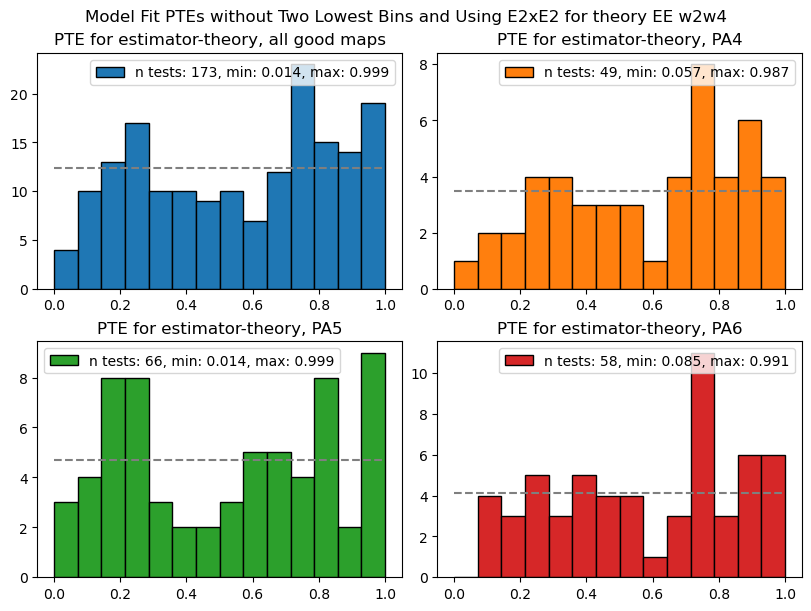

In [36]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Model Fit PTEs without Two Lowest Bins and Using E2xE2 for theory EE w2w4")
#fig.suptitle("Model Fit PTEs without Two Lowest Bins w2w4")
# All maps
axs[0,0].hist(pte_good_maps_without_low_bins,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps_without_low_bins)}, min: {np.min(pte_good_maps_without_low_bins):.3f}, max: {np.max(pte_good_maps_without_low_bins):.3f}')
axs[0,0].hlines(len(pte_good_maps_without_low_bins)/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for estimator-theory, all good maps")
axs[0,0].legend()
# pa4
idx_pa4 = np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]
axs[0,1].hist(pte_good_maps_without_low_bins[idx_pa4], bins=nbins,range=(0.0,1.0), color='tab:orange', edgecolor='black',
             label=f'n tests: {len(pte_good_maps_without_low_bins[idx_pa4])}, min: {np.min(pte_good_maps_without_low_bins[idx_pa4]):.3f}, max: {np.max(pte_good_maps_without_low_bins[idx_pa4]):.3f}')
axs[0,1].hlines(len(pte_good_maps_without_low_bins[idx_pa4])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for estimator-theory, PA4")
axs[0,1].legend()
# pa5
idx_pa5 = np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]
axs[1,0].hist(pte_good_maps_without_low_bins[idx_pa5], bins=nbins,range=(0.0,1.0), color='tab:green', edgecolor='black',
             label=f'n tests: {len(pte_good_maps_without_low_bins[idx_pa5])}, min: {np.min(pte_good_maps_without_low_bins[idx_pa5]):.3f}, max: {np.max(pte_good_maps_without_low_bins[idx_pa5]):.3f}')
axs[1,0].hlines(len(pte_good_maps_without_low_bins[idx_pa5])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for estimator-theory, PA5")
axs[1,0].legend()
# pa6
idx_pa6 = np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]
axs[1,1].hist(pte_good_maps_without_low_bins[idx_pa6], bins=nbins,range=(0.0,1.0), color='tab:red', edgecolor='black',
             label=f'n tests: {len(pte_good_maps_without_low_bins[idx_pa6])}, min: {np.min(pte_good_maps_without_low_bins[idx_pa6]):.3f}, max: {np.max(pte_good_maps_without_low_bins[idx_pa6]):.3f}')
axs[1,1].hlines(len(pte_good_maps_without_low_bins[idx_pa6])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for estimator-theory, PA6")
axs[1,1].legend()
plt.show()
plt.close()

In [10]:
#######################################################
# Array Differencing Null Test
#######################################################
good_maps = np.array(maps[set_pass_all_cuts])
print("Total number of maps passing cuts: ", len(good_maps))
print("Total number of maps: ", n_maps)
print("Number of PA4 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa4')[0]))
print("Total number of PA4 maps: ", len(np.where(map_arrays=='pa4')[0]))
print("Number of PA5 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa5')[0]))
print("Total number of PA5 maps: ", len(np.where(map_arrays=='pa5')[0]))
print("Number of PA6 maps passing cuts: ",len(np.where(map_arrays[set_pass_all_cuts]=='pa6')[0]))
print("Total number of PA6 maps: ", len(np.where(map_arrays=='pa6')[0]))
good_timestamps = np.array([m.split('_')[1] for m in good_maps])
unique_good_timestamps = np.unique(good_timestamps)
print("Number of unique timestamps that pass cuts: ", len(unique_good_timestamps))

# Generating a list of all pairs of indices that need to be processed
# Also makes a list of strings showing which arrays each pair goes with for easy counting
all_pairs = []
all_pairs_array_tags = []
for timestamp in unique_good_timestamps:
    indices = set_pass_all_cuts[np.where(good_timestamps==timestamp)[0]] # Getting indices from full list
    if len(indices)>1:
        pairs = [comb for comb in combinations(indices,r=2)]
        for pair in pairs:
            all_pairs.append(pair)
            all_pairs_array_tags.append(map_arrays[pair[0]]+map_arrays[pair[1]])
all_pairs = np.array(all_pairs)
all_pairs_array_tags = np.array(all_pairs_array_tags)
# Getting indices within all_pairs for each set of arrays
pa4pa5_indices = np.where(all_pairs_array_tags=='pa4pa5')[0]
pa4pa6_indices = np.where(all_pairs_array_tags=='pa4pa6')[0]
pa5pa6_indices = np.where(all_pairs_array_tags=='pa5pa6')[0]
print("Total number of array difference pairs: ", len(all_pairs))
print("Total number of array tags: ", len(all_pairs_array_tags))
print("Number of pa4-pa5 pairs: ", pa4pa5_indices.size)
print("Number of pa4-pa6 pairs: ", pa4pa6_indices.size)
print("Number of pa5-pa6 pairs: ", pa5pa6_indices.size)

Total number of maps passing cuts:  173
Total number of maps:  264
Number of PA4 maps passing cuts:  49
Total number of PA4 maps:  88
Number of PA5 maps passing cuts:  66
Total number of PA5 maps:  92
Number of PA6 maps passing cuts:  58
Total number of PA6 maps:  84
Number of unique timestamps that pass cuts:  69
Total number of array difference pairs:  150
Total number of array tags:  150
Number of pa4-pa5 pairs:  49
Number of pa4-pa6 pairs:  46
Number of pa5-pa6 pairs:  55


In [11]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
chi2_all_pairs = []
pte_all_pairs = []
est_diff_all_pairs = []
cov_sum_all_pairs = []

for pair in all_pairs:
    est_diff = estimators[pair[0]] - estimators[pair[1]]
    cov_sum = covariances[pair[0]] + covariances[pair[1]]
    chi2_pair = np.sum(est_diff**2/(1.0*cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs.append(est_diff)
    cov_sum_all_pairs.append(cov_sum)
    chi2_all_pairs.append(chi2_pair)
    pte_all_pairs.append(pte_pair)
est_diff_all_pairs = np.array(est_diff_all_pairs)
cov_sum_all_pairs = np.array(cov_sum_all_pairs)
chi2_all_pairs = np.array(chi2_all_pairs)
pte_all_pairs = np.array(pte_all_pairs)

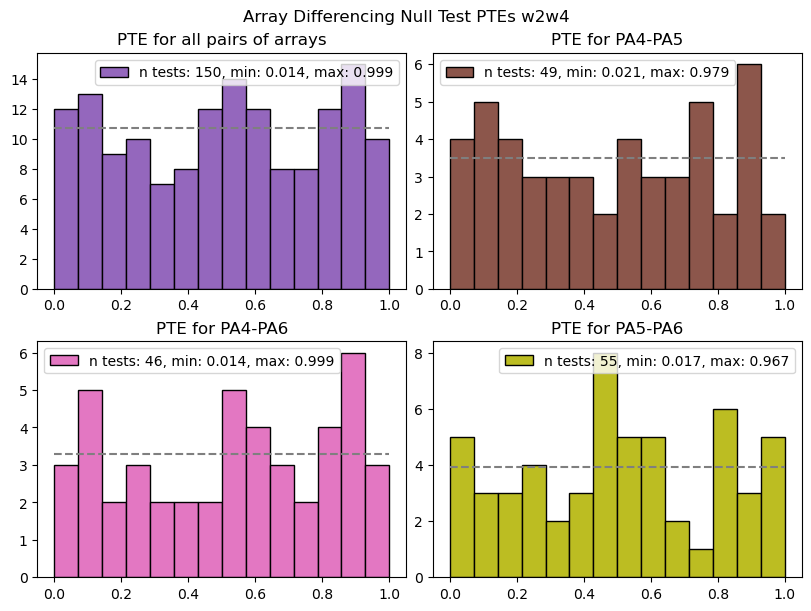

In [34]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Array Differencing Null Test PTEs w2w4")
# All pairs
axs[0,0].hist(pte_all_pairs,bins=nbins,range=(0.0,1.0), color='tab:purple', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs)}, min: {np.min(pte_all_pairs):.3f}, max: {np.max(pte_all_pairs):.3f}')
axs[0,0].hlines(len(pte_all_pairs)/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for all pairs of arrays")
axs[0,0].legend()
# PA4-PA5
axs[0,1].hist(pte_all_pairs[pa4pa5_indices],bins=nbins,range=(0.0,1.0), color='tab:brown', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa4pa5_indices])}, min: {np.min(pte_all_pairs[pa4pa5_indices]):.3f}, max: {np.max(pte_all_pairs[pa4pa5_indices]):.3f}')
axs[0,1].hlines(len(pte_all_pairs[pa4pa5_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for PA4-PA5")
axs[0,1].legend()
# PA4-PA6
axs[1,0].hist(pte_all_pairs[pa4pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:pink', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa4pa6_indices])}, min: {np.min(pte_all_pairs[pa4pa6_indices]):.3f}, max: {np.max(pte_all_pairs[pa4pa6_indices]):.3f}')
axs[1,0].hlines(len(pte_all_pairs[pa4pa6_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for PA4-PA6")
axs[1,0].legend()
# PA5-PA6
axs[1,1].hist(pte_all_pairs[pa5pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:olive', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs[pa5pa6_indices])}, min: {np.min(pte_all_pairs[pa5pa6_indices]):.3f}, max: {np.max(pte_all_pairs[pa5pa6_indices]):.3f}')
axs[1,1].hlines(len(pte_all_pairs[pa5pa6_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for PA5-PA6")
axs[1,1].legend()
plt.show()
plt.close()

In [13]:
# Forming chi-squared for array difference null test and calculating PTE for each pair
# neglecting n number of lower bins
n = 2
chi2_all_pairs_without_low_bins = []
pte_all_pairs_without_low_bins = []
est_diff_all_pairs_without_low_bins = []
cov_sum_all_pairs_without_low_bins = []

for pair in all_pairs:
    est_diff = estimators[pair[0]][n:] - estimators[pair[1]][n:]
    cov_sum = covariances[pair[0]][n:] + covariances[pair[1]][n:]
    chi2_pair = np.sum(est_diff**2/(1.0*cov_sum)) # Assuming expected value of zero for difference of estimators
    dof_pair = est_diff.size - 1 # Should be same each time
    pte_pair = chi2.sf(chi2_pair,dof_pair)
    est_diff_all_pairs_without_low_bins.append(est_diff)
    cov_sum_all_pairs_without_low_bins.append(cov_sum)
    chi2_all_pairs_without_low_bins.append(chi2_pair)
    pte_all_pairs_without_low_bins.append(pte_pair)
est_diff_all_pairs_without_low_bins = np.array(est_diff_all_pairs_without_low_bins)
cov_sum_all_pairs_without_low_bins = np.array(cov_sum_all_pairs_without_low_bins)
chi2_all_pairs_without_low_bins = np.array(chi2_all_pairs_without_low_bins)
pte_all_pairs_without_low_bins = np.array(pte_all_pairs_without_low_bins)

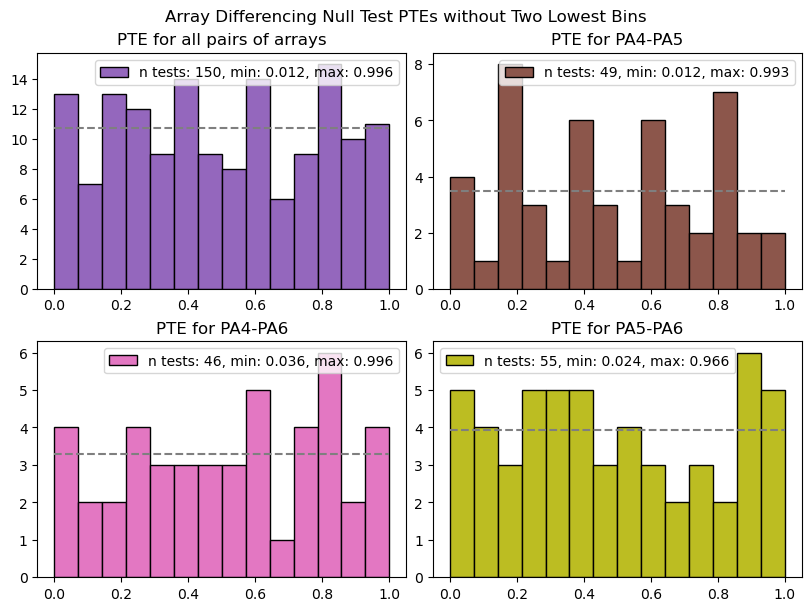

In [25]:
# Making PTE distribution plots 
nbins = 14   # Have been using 10; ACT DR6 papers seem to use 14 for their null tests
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(8,6))
fig.suptitle("Array Differencing Null Test PTEs without Two Lowest Bins")
# All pairs
axs[0,0].hist(pte_all_pairs_without_low_bins,bins=nbins,range=(0.0,1.0), color='tab:purple', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs_without_low_bins)}, min: {np.min(pte_all_pairs_without_low_bins):.3f}, max: {np.max(pte_all_pairs_without_low_bins):.3f}')
axs[0,0].hlines(len(pte_all_pairs_without_low_bins)/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,0].set_title("PTE for all pairs of arrays")
axs[0,0].legend()
# PA4-PA5
axs[0,1].hist(pte_all_pairs_without_low_bins[pa4pa5_indices],bins=nbins,range=(0.0,1.0), color='tab:brown', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs_without_low_bins[pa4pa5_indices])}, min: {np.min(pte_all_pairs_without_low_bins[pa4pa5_indices]):.3f}, max: {np.max(pte_all_pairs_without_low_bins[pa4pa5_indices]):.3f}')
axs[0,1].hlines(len(pte_all_pairs_without_low_bins[pa4pa5_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[0,1].set_title("PTE for PA4-PA5")
axs[0,1].legend()
# PA4-PA6
axs[1,0].hist(pte_all_pairs_without_low_bins[pa4pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:pink', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs_without_low_bins[pa4pa6_indices])}, min: {np.min(pte_all_pairs_without_low_bins[pa4pa6_indices]):.3f}, max: {np.max(pte_all_pairs_without_low_bins[pa4pa6_indices]):.3f}')
axs[1,0].hlines(len(pte_all_pairs_without_low_bins[pa4pa6_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,0].set_title("PTE for PA4-PA6")
axs[1,0].legend()
# PA5-PA6
axs[1,1].hist(pte_all_pairs_without_low_bins[pa5pa6_indices],bins=nbins,range=(0.0,1.0), color='tab:olive', edgecolor='black',
             label=f'n tests: {len(pte_all_pairs_without_low_bins[pa5pa6_indices])}, min: {np.min(pte_all_pairs_without_low_bins[pa5pa6_indices]):.3f}, max: {np.max(pte_all_pairs_without_low_bins[pa5pa6_indices]):.3f}')
axs[1,1].hlines(len(pte_all_pairs_without_low_bins[pa5pa6_indices])/nbins, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
axs[1,1].set_title("PTE for PA5-PA6")
axs[1,1].legend()
plt.show()
plt.close()

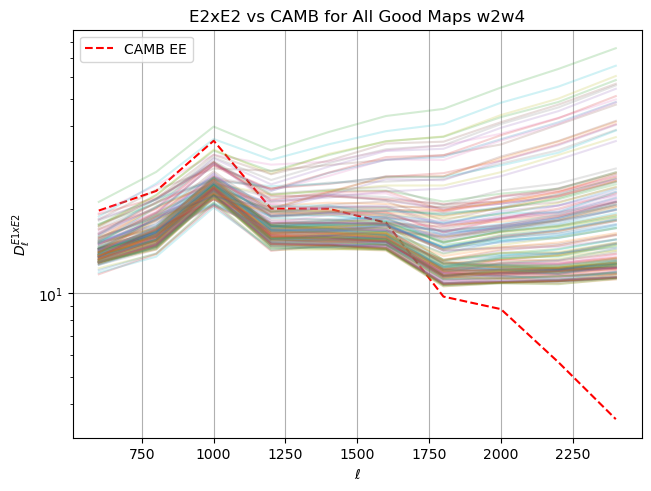

In [33]:
def cl_to_dl(cl, ell):
    """Helper function to convert C_ell to D_ell"""
    return cl*ell*(ell+1.0) / (2.0 * np.pi)
ell = spectra_dict[maps[0]]['ell']
# Plotting all the E2xE2 spectra to see how much lower than CAMB EE they are for the good maps
fig = plt.figure(figsize=(6.4,4.8), layout='constrained')
plt.semilogy(ell, cl_to_dl(spectra_dict[maps[0]]['CAMB_EE'],ell), 'r--', label="CAMB EE")
for i in range(len(maps)):
    if i in set_pass_all_cuts:
        plt.semilogy(ell, cl_to_dl(spectra_dict[maps[i]]['E2xE2'],ell),alpha=0.2)
    else:
        continue
plt.ylabel("$D_{\ell}^{E1xE2}$")
plt.xlabel("$\ell$")
plt.grid()
plt.legend()
plt.title("E2xE2 vs CAMB for All Good Maps w2w4")
plt.show()
plt.close()